**Model Source:**<br />
https://github.com/kuangliu/pytorch-cifar/blob/49b7aa97b0c12fe0d4054e670403a16b6b834ddd/models/dla_simple.py

# Setup Variables

MNIST, FashionMNIST, GTSRB, Cifar10

In [1]:
DATASET = 'GTSRB'
SEED = 42
CUDA = 0
GPU_NAME = f'cuda:{CUDA}'

In [2]:
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring')

# Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from fastprogress import progress_bar, master_bar

import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchinfo import summary


cudnn.benchmark = True
torch.set_float32_matmul_precision('high')

In [3]:
from utilities.utils import *
from utilities.pathManager import fetchPaths
from utilities.scaleFunctions import *
from utilities.pcaFunctions import *

In [4]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

## Load model and settings

In [ ]:
from models.mnist_model import MNIST_Model
from models.fashionmnist_model import FashionMNIST_CNN
from models.gtsrb_model import GTSRB_CNN
from models.cifar10_dla import Cifar10_DLA
from models.cifar10_model import Cifar10_CNN

from models.transformers import transformers

models = {
    'mnist': MNIST_Model,
    'fashionmnist': FashionMNIST_CNN,
    'gtsrb': GTSRB_CNN,
#     'cifar10': Cifar10_DLA,
    'cifar10': Cifar10_CNN
}

model_ = models[DATASET.lower()]
transformer = transformers[DATASET.lower()]

# Paths

In [9]:
paths = fetchPaths(base, DATASET, '', False)

path_data = paths['data']
path_lhl = paths['lhl']
path_stats = paths['saved_models'].parent.parent

configs = load_json(paths['configuration'])
config = configs['configuration']
model_setup = configs['model_setup']
model_config = configs['model_config']
optim_name = list(config['optimizer'].keys())[0]
optim_args = config['optimizer'][optim_name]
scheduler_name = list(config['scheduler'].keys())[0]
scheduler_args = config['scheduler'][scheduler_name]

# GPU Device & Seed

In [8]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [9]:
device = get_device(GPU_NAME)
torch.cuda.get_device_name(device)

'NVIDIA A100 80GB PCIe'

# Load / Split / DataLoader

In [10]:
feature_names = get_labels(DATASET)

train_data = get_dataset(DATASET, path_data, train=True, transform=transformer['train'])
test_data = get_dataset(DATASET, path_data, train=False, transform=transformer['test'])
len(train_data), len(test_data)

(63999, 4223)

In [11]:
trainloader = get_dataLoader(train_data, model_config['batch_size'], True)
testloader = get_dataLoader(test_data, model_config['batch_size'], False)

In [12]:
tf_denormalize = T.Normalize(
    mean=[-m / s for m, s in zip(transformer['train'].transforms[-1].mean, transformer['train'].transforms[-1].std)],
    std=[1/s for s in transformer['train'].transforms[-1].std]
)

In [13]:
# get_mean_std(DataLoader(train_data, 2048))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


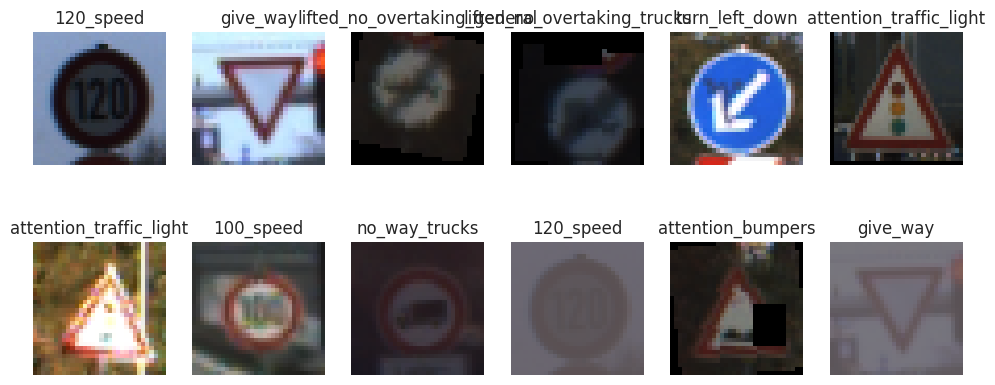

In [22]:
show_images_loader(trainloader, feature_names=feature_names, transform=tf_denormalize)

# Helper Functions

In [23]:
def create_model(lhl):
    
    # model
    model_setup['last_hidden_neurons'] = lhl
    
    # torch 2.0 compile and parallel data training
    model = model_(**model_setup).to(device)
    model = torch.compile(model)
    nn.DataParallel(model, device_ids=[CUDA])
    
    # loss function
    loss_function = nn.CrossEntropyLoss()
    
    # optimizer and scheduler
    optimizer = getattr(torch.optim, optim_name)(model.parameters(), lr=model_config['lr'], **optim_args)
    scheduler = getattr(torch.optim.lr_scheduler, scheduler_name)(optimizer, **scheduler_args)
        
    return model, loss_function, optimizer, scheduler

In [24]:
def create_folders(postfix):
    model_name = f'{DATASET}_{postfix}'
    paths = fetchPaths(base, DATASET, postfix)
    path_saved_model = paths['saved_models']
    path_lhl_raw = paths['lhl_raw']
    
    return model_name, path_saved_model, path_lhl_raw

In [25]:
def start_training_testing(model_name, model, loss_function, optimizer, scheduler):
    # training testing attributes
    kwargs = {
        'model': model,
        'loss_function': loss_function,
        'optimizer': optimizer,
        'lr_scheduler': scheduler,
        'map_classes': None,
        'skip_classes': None,
        'device': device,
        'model_path': path_saved_model / f"{model_name}.pth.tar",
        'trainloader': trainloader,
        'testloader': testloader,
        'config': model_config
    }

    # run training testing
    return run_training_testing(**kwargs)

## Run Training

In [ ]:
model_stats = pd.DataFrame({
    'lhl':pd.Series(dtype=str),
    'optim':pd.Series(dtype=str),
    'scheduler':pd.Series(dtype=str),
    'epochs':pd.Series(dtype=np.uint8),
    'best_epoch':pd.Series(dtype=np.uint8),
    'train_losses':pd.Series(dtype=object),
    'test_losses':pd.Series(dtype=object),
    'train_accs':pd.Series(dtype=object),
    'test_accs':pd.Series(dtype=object),
    'test_loss':pd.Series(dtype=np.float32),
    'test_acc':pd.Series(dtype=np.float32)
})

for lhl in config['lhl_neurons']:

    # model postfix
    postfix = f"{optim_name}-{model_config['batch_size']}-{lhl}"
    model_name, path_saved_model, path_lhl_raw = create_folders(postfix)
    
    # create model
    model, loss_function, optimizer, scheduler = create_model(lhl)
    
    # skip train and only load if exists
    skip_train = len(list(path_saved_model.glob(f'{model_name}*.pth.tar'))) != 0
    
    if skip_train: continue
        
    # train
    train_losses, test_losses, train_accs, test_accs, test_loss, test_acc, confusion_matrix_test, best_model_name = \
    start_training_testing(model_name, model, loss_function, optimizer, scheduler)
    
    # save stats
    model_stats.loc[model_stats.shape[0]+1] = [lhl, optim_name, scheduler_name, len(train_losses), np.argmax(test_accs), train_losses, test_losses, train_accs, test_accs, test_loss, test_acc]

    # load best model
    load_checkpoint(model, best_model_name)
    
    # normalize and save matrix
    confusion_matrix_test_norm = normalize_confusion_matrix(confusion_matrix_test)
    save_confusion_matrix(confusion_matrix_test_norm, path_saved_model, model_name, 'test')
    
    # export last hidden layer data
    export_last_hidden_layer(trainloader, model, device, lhl, None, path_lhl_raw, model_name, 'raw_train')
    export_last_hidden_layer(testloader, model, device, lhl, None, path_lhl_raw, model_name, 'raw_test')

[2023-07-15 20:16:36,829] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


In [ ]:
# save model stats csv
model_stats.to_csv(path_stats / f'{DATASET}_model_stats.csv', index=False)

## Export PCA

In [ ]:
for lhl in config['lhl_neurons']:
    
    # model postfix
    postfix = f"{optim_name}-{model_config['batch_size']}-{lhl}"
    model_name = f"{DATASET}_{postfix}"

    # get paths
    paths_ = fetchPaths(base, DATASET, postfix)
    p_lhl = paths_['lhl']
    p_lhl_raw = paths_['lhl_raw']
    p_lhl_pca = paths_['lhl_pca']
    p_lhl_scaler_pca = paths_['lhl_scaler_pca']
    
    # load data
    train = pd.read_csv(p_lhl_raw / f'{model_name}_raw_train.csv')
    true = train.loc[train['true'] == True]
    test = pd.read_csv(p_lhl_raw / f'{model_name}_raw_test.csv')
    
    # fit scaler and pca
    scaler_ = fitStandardScalerSingle(true, lhl)
    pca_ = fitPCASingle(true, scaler=None, numNeurons=lhl)
    scaler_pca_ = fitPCASingle(true, scaler=scaler_, numNeurons=lhl)
    
    # save objects
    save_pickle(p_lhl / 'scaler.pkl', scaler_)
    save_pickle(p_lhl / 'pca.pkl', pca_)
    save_pickle(p_lhl / 'scaler_pca.pkl', scaler_pca_)

    # transform and save data
    ## train
    applyPCASingle(pca_, train, scaler=None, numNeurons=lhl).to_csv(p_lhl_pca / f'{model_name}_pca_train.csv', index=False)
    applyPCASingle(scaler_pca_, train, scaler=scaler_, numNeurons=lhl).to_csv(p_lhl_scaler_pca / f'{model_name}_scaler_pca_train.csv', index=False)
    
    ## test
    applyPCASingle(pca_, test, scaler=None, numNeurons=lhl).to_csv(p_lhl_pca / f'{model_name}_pca_test.csv', index=False)
    applyPCASingle(scaler_pca_, test, scaler=scaler_, numNeurons=lhl).to_csv(p_lhl_scaler_pca / f'{model_name}_scaler_pca_test.csv', index=False)
    
    # save selected neurons
    save_json(p_lhl / 'neurons_pca.json', neuronsLoadingsSingle(pca_, numNeurons=None, var_thld=0.9, loadings_thld=0.5))
    save_json(p_lhl / 'neurons_scaler_pca.json', neuronsLoadingsSingle(scaler_pca_, numNeurons=None, var_thld=0.9, loadings_thld=0.5))